In [102]:
import numpy as np
from typing import Callable
import matplotlib
import matplotlib.pyplot as plt
# Do not pick MacOsx because it will crash the jupyter kernel 
#matplotlib.use('nbAgg')  # Replace 'TkAgg' with your preferred backend

# The goal is to express all polynomials with a neural network that only uses relu activation functions
# many thanks to Nikolaj-K @ https://www.youtube.com/watch?v=PApGm1TKFHQ for the topic
# rewrote it in a different way

# Utils


In [103]:
def plot(x: np.ndarray) -> Callable[[np.ndarray,str,str], None]:
    """
    Curries X into the plot function
    """
    def fn(y: np.ndarray, label: str, color: str) -> None:
        plt.plot(x, y, label=label, color=color)
    return lambda y,label,color : fn(y,label,color)


def plt_setup(xlim:tuple = (0,1), ylim:tuple = (0,1), title:str = "getting $a*(X^2)+b$ from Relus is the goal") -> None:
    plt.grid(True)
    # plt.style.use('dark_background')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.style.use('dark_background')
    return None

color_cycle = matplotlib.colormaps["Spectral"]

X=np.arange(0,1,0.001)
p = plot(X)


# STEP 1 : get X^2 from adding piecewise linear functions (triangle wave functions)

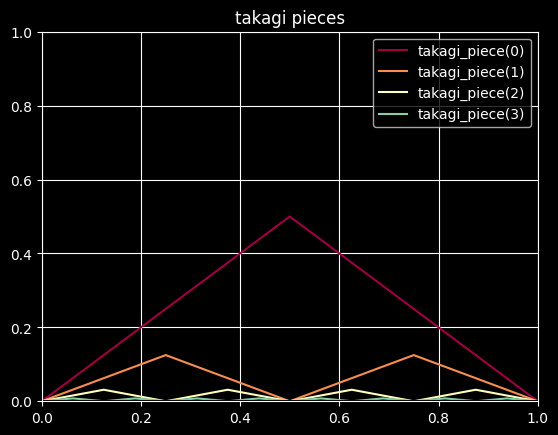

In [104]:
def triangle_wave(x: np.ndarray) -> np.ndarray:
    """ 
    we call this $S_n(x)$ below
    """
    left = x-np.floor(x)
    right = np.ceil(x)-x
    return (left < right)*left + (left >= right)*right


def takagi(N: int) -> np.ndarray:
    # https://en.wikipedia.org/wiki/Blancmange_curve
    return np.stack([takagi_piece(i) for i in range(N)], axis=1).sum(axis=1)


def takagi_piece(i: int) -> np.ndarray:
    w = 0.25  # w=1/4 gives the parabola !
    return (w**i) * triangle_wave((2**i)*X)


# Let's print the takagi pieces once by one and see what they look like
p(takagi_piece(0), "takagi_piece(0)", color=color_cycle(0.0))
p(takagi_piece(1), "takagi_piece(1)", color=color_cycle(0.25))
p(takagi_piece(2), "takagi_piece(2)", color=color_cycle(0.5))
p(takagi_piece(3), "takagi_piece(3)", color=color_cycle(0.75))
plt_setup(title="takagi pieces")
plt.legend(loc="best")
plt.show()

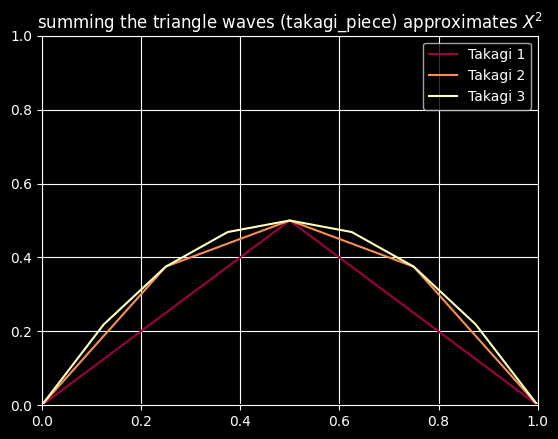

In [105]:
p(takagi(1), "Takagi 1", color=color_cycle(0.0))
p(takagi(2), "Takagi 2", color=color_cycle(0.25))
p(takagi(3), "Takagi 3", color=color_cycle(0.50))
plt_setup(title="summing the triangle waves (takagi_piece) approximates $X^2$")
plt.legend(loc='best')
plt.show()

# Step 2 : get the triangle wave functions from Relus

Now we will try to recreate this but only with linear combinations of Relus and shifted relus (essentially a neural network with 1 input x, Relus as the activation function) 

In [106]:
class TensorFunction:
    def __init__(self, func: Callable[[np.ndarray], np.ndarray]):
        self.func = func

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.func(x)

    def __add__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) + other(x))
        else:
            raise ValueError("Unsupported type for addition")

    def __sub__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) - other(x))
        else:
            raise ValueError("Unsupported type for subtraction")

    def __mul__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) * other(x))
        elif isinstance(other, (int, float)):
            return TensorFunction(lambda x: self(x) * other)
        else:
            raise ValueError("Unsupported type for multiplication")

    def __rmul__(self, other):
        return self.__mul__(other)

    def __neg__(self):
        return TensorFunction(lambda x: -self(x))
    
    def shift(self, shift: float):
        return TensorFunction(lambda x: self(x - shift))


# BASIC FUNCTIONS
# The only TensorFunction we need to get all polynomials is Relu!

Relu = TensorFunction(lambda x : np.maximum(x,0))

# Now we will construct the primitives $\forall n \in \mathbb{N}^* , P_n : [0,1] \to [0,\frac{1}{2}]$

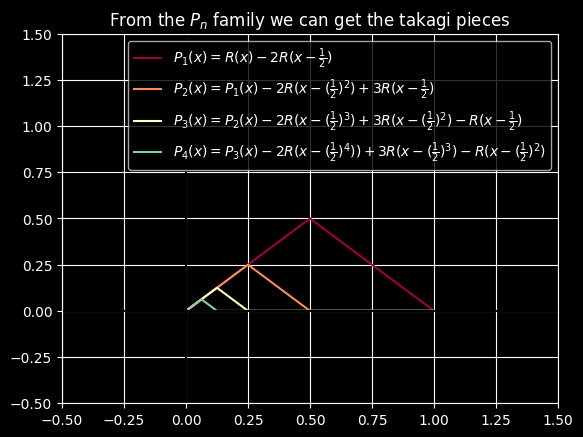

In [107]:
# We cut in half the frist relu and create a triangle
P_1 = Relu-2*Relu.shift(0.5)

p(P_1(X), "$P_1(x) = R(x) - 2R(x-\\frac{1}{2})$", color=color_cycle(0.0))

P_2 = P_1 - 2*Relu.shift(0.25) + 3*Relu.shift(0.5)

p(P_2(X), "$P_2(x)=P_1(x)-2R(x-(\\frac{1}{2})^2)+3R(x-\\frac{1}{2})$", color=color_cycle(0.25))

P_3 = P_2 - 2*Relu.shift(0.125) + 3*Relu.shift(0.25) - Relu.shift(0.5)

p(P_3(X), "$P_3(x)=P_2(x)-2R(x-(\\frac{1}{2})^3)+3R(x-(\\frac{1}{2})^2)-R(x-\\frac{1}{2})$", color=color_cycle(0.5))

P_4 = P_3 - 2*Relu.shift(0.0625) + 3*Relu.shift(0.125) - Relu.shift(0.25)

p(P_4(X), "$P_4(x)=P_3(x)-2R(x-(\\frac{1}{2})^4))+3R(x-(\\frac{1}{2})^3)-R(x-(\\frac{1}{2})^2)$", color=color_cycle(0.75))

plt_setup(xlim=(-0.5,1.5), ylim=(-0.5,1.5), title="From the $P_n$ family we can get the takagi pieces" )
plt.legend(loc='best')
plt.show()

Now we have a family of primitive functions for the triangle wave function at every scale in the interval [0,1]

The general formula to obtain $P_n$ the nth primitive is : 

$P_{n} = P_{n-1} - 2R(x-(1/2)^{n+2}) + 3R(x-(1/2)^{n+1}) - R(x-(1/2)^n)$


We call $T_n : x \in [0,1] \to T_n(x) \in [0,1/2]$ the triangle wave function that has $2^{n-1}$ peaks on $[0,1]$

# Now we will create $T_n$ by adding shifted primitives together

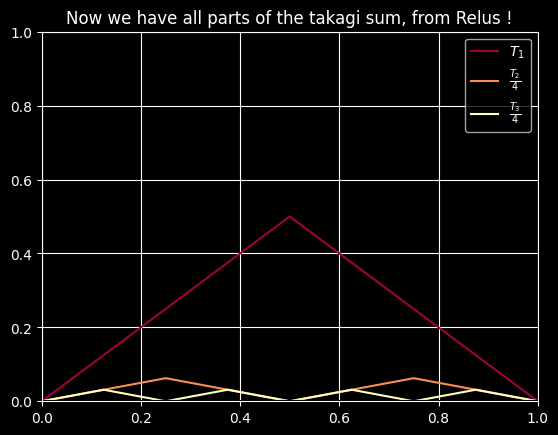

In [108]:
# we scale each ofg them by 1/4 to get the takagi pieces 

T_1 = P_1

p(T_1(X), "$T_1$", color=color_cycle(0.0))

T_2 = 0.25*(P_2 + P_2.shift(0.5))

p(T_2(X), "$\\frac{T_2}{4}$", color=color_cycle(0.25))

T_3 = 0.25*(P_3 + P_3.shift(0.5) + P_3.shift(0.25) + P_3.shift(0.75))

p(T_3(X), "$\\frac{T_3}{4}$", color=color_cycle(0.5))

plt_setup(xlim=(0,1), ylim=(0,1), title="Now we have all parts of the takagi sum, from Relus !" )
plt.legend(loc='best')
plt.show()

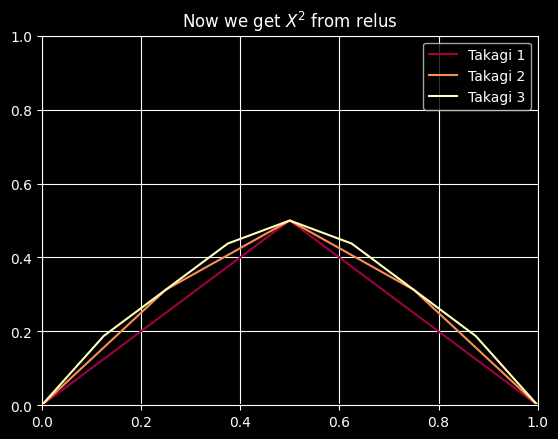

In [109]:
p(T_1(X), "Takagi 1", color=color_cycle(0.0))
p(T_1(X)+T_2(X), "Takagi 2", color=color_cycle(0.25))
p(T_1(X)+T_2(X)+T_3(X), "Takagi 3", color=color_cycle(0.50))

plt_setup(xlim=(0,1), ylim=(0,1), title="Now we get $X^2$ from relus" )
plt.legend(loc='best')
plt.show()

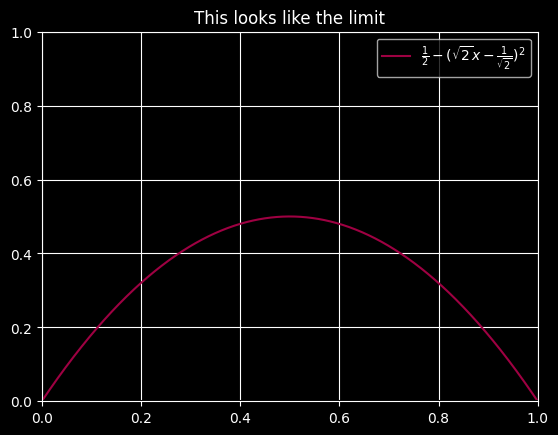

In [110]:
limit = lambda x : 0.5-((2**0.5)*x-1/(2**0.5))**2
l = TensorFunction(lambda x: limit(x))(X)
p(l, "$\\frac{1}{2}-(\\sqrt{2}x-\\frac{1}{\\sqrt{2}})^2$", color=color_cycle(0.0))
plt_setup(xlim=(0,1), ylim=(0,1), title="This looks like the limit" )
plt.legend(loc='best')
plt.show()

# Now let's get a neural network to learn this and then inspect its weights and see if it corresponds to what we constructed

In [115]:
# let's use tinygrad because it's very simple
# and lightweight
from tinygrad.tensor import Tensor
from tinygrad import nn
from tinygrad.nn.optim import Optimizer

# from tinygrad.extra.lr_scheduler import LR_Scheduler, ReduceLROnPlateau

In [136]:
# from tinygrad.extra
class LR_Scheduler:
  def __init__(self, optimizer: Optimizer):
    self.optimizer = optimizer
    self.epoch_counter = Tensor([0], requires_grad=False, device=self.optimizer.device)

  def get_lr(self): pass

  def step(self) -> None:
    self.epoch_counter.assign(self.epoch_counter + 1).realize()
    self.optimizer.lr.assign(self.get_lr()).realize()

class OneCycleLR(LR_Scheduler):
  def __init__(self, optimizer: Optimizer, max_lr: float, div_factor: float, final_div_factor: float, total_steps: int, pct_start: float):
    super().__init__(optimizer)
    self.initial_lr = max_lr / div_factor
    self.max_lr = max_lr
    self.min_lr = self.initial_lr / final_div_factor
    self.total_steps = total_steps
    self.pct_start = pct_start
    self.optimizer.lr.assign(self.get_lr()).realize() # update the initial LR

  @staticmethod
  def _annealing_linear(start: float, end: float, pct: Tensor) -> Tensor: return (pct*(end-start)+start)

  def get_lr(self) -> Tensor:
    return (self.epoch_counter < self.total_steps*self.pct_start).where(
      self._annealing_linear(self.initial_lr, self.max_lr, self.epoch_counter/(self.total_steps*self.pct_start)),
      self._annealing_linear(self.max_lr, self.min_lr, (self.epoch_counter-(self.total_steps*self.pct_start))/(self.total_steps*(1-self.pct_start)))
    )

lr = 0.0011978022521361709
loss at train_step = 0 : 0.2015710324048996
lr = 0.020978020504117012
loss at train_step = 100 : 0.002650398062542081
lr = 0.04075824096798897
loss at train_step = 200 : 0.002063005929812789
lr = 0.060538459569215775
loss at train_step = 300 : 0.0017523412825539708
lr = 0.08031868189573288
loss at train_step = 400 : 0.0015917730052024126
lr = 0.09990011155605316
loss at train_step = 500 : 0.0009536994621157646
lr = 0.07992208749055862
loss at train_step = 600 : 0.0008591493824496865
lr = 0.059944067150354385
loss at train_step = 700 : 0.0008199462317861617
lr = 0.039966046810150146
loss at train_step = 800 : 0.0008019204251468182
lr = 0.01998802460730076
loss at train_step = 900 : 0.0007922196527943015
lr = 1.0002695489674807e-05
loss at train_step = 1000 : 0.00079114775871858


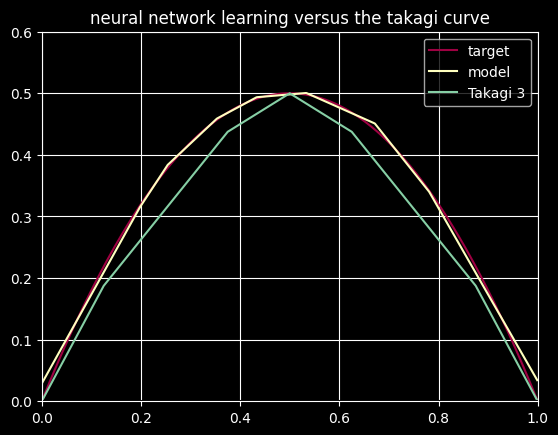

In [147]:
# First we generate the X2 data from the takagi sum
class Model:

    def __init__(self, hidden_state: int) -> None:
        self.hidden_layer = nn.Linear(1, hidden_state)
        self.output_layer = nn.Linear(hidden_state, 1)

    def __call__(self, x: Tensor) -> Tensor:
        return self.output_layer(self.hidden_layer(x).relu())
    
    def L1(self) -> Tensor:
        return self.hidden_layer.weight.abs().sum() + self.hidden_layer.bias.abs().sum() + self.output_layer.weight.abs().sum() + self.output_layer.bias.abs().sum()
    
    def L2(self) -> Tensor:
        return self.hidden_layer.weight.square().sum() + self.hidden_layer.bias.square().sum() + self.output_layer.weight.square().sum() + self.output_layer.bias.square().sum()

def target(x: Tensor) -> Tensor:
    return 0.5-((2**0.5)*x-1/(2**0.5))**2


def train_step(x:Tensor, y:Tensor, model: Model, opt: nn.optim.LAMB, lr_schedule: LR_Scheduler) -> Tensor:
    y_pred = model(x)
    loss = (y_pred - y).square().mean() + 0.0001 * (model.L2())# + 0.0001 * (model.L2())
    opt.zero_grad()
    loss.backward()
    opt.step()
    lr_schedule.step()
    return loss


def train_model(hidden_units:int = 2, lr:float = 0.01, steps:int = 1001, bs:int = 32768) -> Model:
    model = Model(hidden_state=hidden_units)
    opt = nn.optim.Adam(nn.state.get_parameters(model), lr)
    lr_schedule = OneCycleLR(opt, max_lr=0.1, div_factor=100, final_div_factor=100, total_steps=steps, pct_start=0.5)
    old_lr = opt.lr.numpy()
    for i in range(steps):
        samples = Tensor.rand(bs, 1).realize()
        y = target(samples)
        loss = train_step(samples, y, model, opt, lr_schedule)
        if i%100 == 0:
            print(f"lr = {opt.lr.numpy()[0]}")
            print(f"loss at train_step = {i} : {loss.numpy()}")
    return model

def plot_model(model) -> None:
    p(target(Tensor(X.astype(np.float32)).reshape(-1,1)).numpy(), "target", color=color_cycle(0.0))
    p(model(Tensor(X.astype(np.float32)).reshape(-1,1)).numpy(), "model", color=color_cycle(0.5))
    p(T_1(X)+T_2(X)+T_3(X), "Takagi 3", color=color_cycle(0.75))
    plt_setup(xlim=(0,1), ylim=(0,1/2+0.1), title="neural network learning versus the takagi curve" )
    plt.legend(loc='best')
    plt.show()

# P_1 is 2 hidden units
# P_2 is 4 hidden units
# P_3 is 10 hidden units 
# T_1 is 2 hidden units (T_1=P_1)
# T_2 is 8 hidden units (2 P_2s)
# T_3 is 40 hidden units (4 P3s)
# T_1 + T_2 + T_3 is 50 hidden units
model = train_model(hidden_units=50)
plot_model(model) # will this converge to Takagi 1 ? 

The neural network found a better combination of relus than we did !